Directory 'reservoir' already exists in the current working directory.
Directory 'result' already exists in the current working directory.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Ratio of Reduced Retain Set to Retain Set:  0.10101010101010101


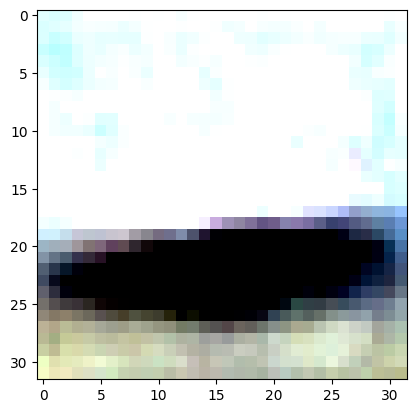

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


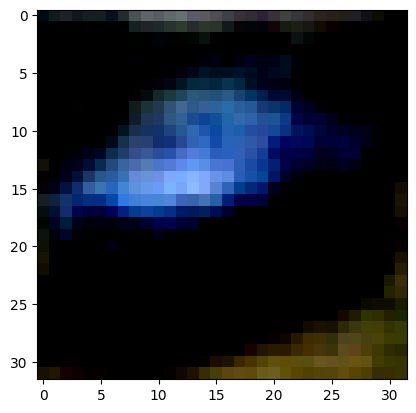

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


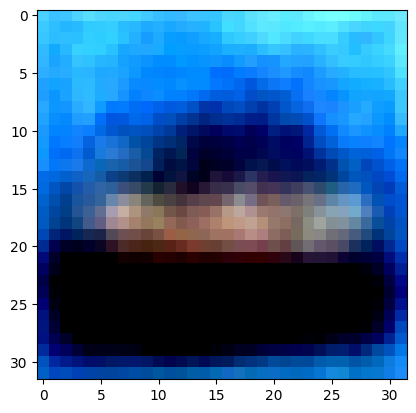

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


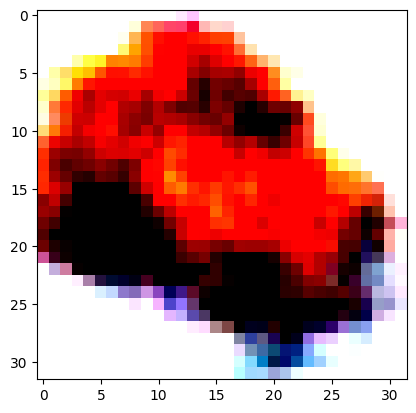

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


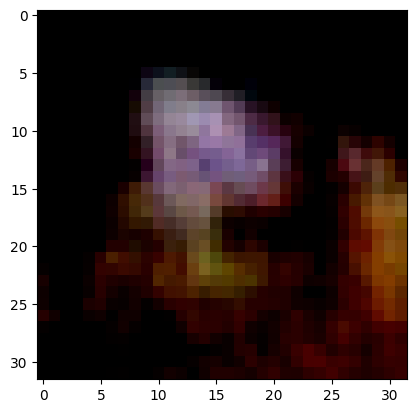

In [3]:
import warnings
warnings.filterwarnings('ignore')
import os
import torch
import torch.nn as nn
import numpy as np
import time
import copy
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np
from scipy.ndimage import rotate as scipyrotate
from torchvision import datasets, transforms
import random
import matplotlib.pyplot as plt
import time
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
from sklearn import linear_model, model_selection
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
from sklearn import linear_model, model_selection
import torchvision.models as models
from sklearn.cluster import KMeans
import pandas as pd
import torch
from torch.utils.data import DataLoader
import pickle
from torchvision.models import resnet18

from modular_unlearn.offline_training import *
from modular_unlearn.ds_condensation_imrpvDM import *
from modular_unlearn.modular_forgetting import *
from modular_unlearn.unlearning_metric import *
from auxil.auxils import *
from model.model import *
from auxil.retrain import *
from auxil.distillation import *
from auxil.sparisification import *
from auxil.bad_distillation import *
from auxil.mia_forget_logit import *


directory_name= 'reservoir'
current_path = os.getcwd()  
new_directory_path = os.path.join(current_path, directory_name)  

if not os.path.exists(new_directory_path): 
    os.makedirs(new_directory_path) 
    print(f"Directory '{directory_name}' created in the current working directory.")
else:
    print(f"Directory '{directory_name}' already exists in the current working directory.")


dat_dir='result'
result_directory_path = os.path.join(current_path, dat_dir)

if not os.path.exists(result_directory_path):
    os.makedirs(result_directory_path)
    print(f"Directory '{dat_dir}' created in the current working directory.")
else:
    print(f"Directory '{dat_dir}' already exists in the current working directory.")

#----------------------Hyperparameters---------------------------------
device= torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
batch_size = 256
batch_syn=32
channel = 3
im_size = (32, 32)
hidden_size=128
num_classes = 10
lr_proposed=1e-3

lr_overture=1e-3
lr_intermediate=1e-3
overture_epochs=10
beggining_epochs=1
final_epochs = 10
intermediate_epochs= 1
final_thr=15  # intended for blocking the final training in overture, 
            # from the end of overture epochs--> improves retain acc while preserving forget accuracy



retrain_lr=1e-3
retrain_epochs=20


partial_retain_ratio=0.3
#------------------------------------------------------------------------


#----------------------------Loading stuff------------------------------------------------------------------------
criterion = nn.CrossEntropyLoss()

file_path = os.path.join(new_directory_path,'Klabels_labels_dict.pkl')
with open(file_path, 'rb') as file:
    original_labels_dict = pickle.load(file)

file_path = os.path.join(new_directory_path,'forget_set.pth')
forget_set_real = torch.load(file_path)
file_path = os.path.join(new_directory_path,'retain_set.pth')
retain_set_real = torch.load(file_path)

file_path = os.path.join(new_directory_path,'test_set.pth')
dst_test = torch.load(file_path)
file_path = os.path.join(new_directory_path,'indices.pth')
indices = torch.load(file_path)
file_path = os.path.join(new_directory_path,'forget_indices.pth')
forget_indices = torch.load(file_path)
file_path = os.path.join(new_directory_path,'retain_indices.pth')
retain_indices = torch.load(file_path)
file_path = os.path.join(new_directory_path,'clustered_label_train.pth')
new_lab_train = torch.load(file_path)
file_path = os.path.join(new_directory_path,'image_train.pth')
train_images = torch.load(file_path)
file_path = os.path.join(new_directory_path,'label_train.pth')
train_labels = torch.load(file_path)
file_path = os.path.join(new_directory_path,'syn_set.pth')
img_syn_dataset = torch.load(file_path)
file_path = os.path.join(new_directory_path,'reduced_retain_images.pth')
reduced_retain_images=torch.load(file_path)
file_path = os.path.join(new_directory_path,'reduced_retain_labels.pth')
reduced_retain_labels=torch.load(file_path)
file_path = os.path.join(new_directory_path,'inverted_IMG.pth')
inverted_IMG=torch.load(file_path)
file_path = os.path.join(new_directory_path,'inverted_LABEL.pth')
inverted_LABEL=torch.load(file_path)
file_path = os.path.join(new_directory_path,'indices_train_wrt_bucket.pth')
indices_train_wrt_bucket=torch.load(file_path)
file_path = os.path.join(new_directory_path,'bucket_labbies.pth')
bucket_labbies=torch.load(file_path)


img_real_data_dataset=TensorDatasett(train_images, train_labels)
img_real_data_loader=torch.utils.data.DataLoader(img_real_data_dataset, batch_size=batch_size, shuffle=True)
forget_loader=torch.utils.data.DataLoader(forget_set_real, batch_size=batch_size, shuffle=True)
retain_loader=torch.utils.data.DataLoader(retain_set_real, batch_size=batch_size, shuffle=True)
img_syn_loader=torch.utils.data.DataLoader(img_syn_dataset, batch_size=batch_syn, shuffle=True)
test_loader=torch.utils.data.DataLoader(dst_test, batch_size=batch_size, shuffle=True)
reduced_retain_dataset=TensorDatasett(reduced_retain_images,reduced_retain_labels)
reduced_retain_loader=torch.utils.data.DataLoader(reduced_retain_dataset, batch_size=batch_size, shuffle=True)

# sample the retain_set_real by partial_retain_ration
partial_retain_set_real = torch.utils.data.Subset(retain_set_real, random.sample(range(len(retain_set_real)), int(len(retain_set_real)*partial_retain_ratio)))


comp_ratio = len(reduced_retain_loader.dataset)/len(retain_loader.dataset)
print("Ratio of Reduced Retain Set to Retain Set: ", comp_ratio)
file_path = os.path.join(result_directory_path,'ratio_reduced_retain_set_to_retain_set.txt')
with open(file_path, 'w') as file:
    file.write("Dataset Compression Ratio: "+str(comp_ratio))

for i in range(5):
    img_syn=inverted_IMG[random.randint(0,len(inverted_IMG)-1)]
    plt.imshow(img_syn.permute(1, 2, 0).cpu().numpy())
    plt.show()